```
---
title: Generation of summary of a set of reactions in BioPAX: Reactome use case
tags: BioPAX, smallMolecules, reaction, genericity, SPARQL, Reactome, ChEBI
lang: en
version: 0.4
date: 2023-05-12
---
```

In [1]:
import graphviz
import importlib
import json
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

In [2]:
#reactomeVersion = 83 # was 81
reactomeVersion = 84 # was 81
chebiVersion = 219 # was 207
#endpointURL = "http://localhost:3030/reactome/query"
#endpointURL = "http://localhost:3030/chebi/query"
endpointURL = "http://localhost:3030/reactomeChEBI/query"
rdfFormat = "turtle"

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>

# Homo_sapiens-20170221.owl
#PREFIX reactome: <http://www.reactome.org/biopax/59/48887#> 
#
# Homo_sapiens-20210608.owl
#PREFIX reactome: <http://www.reactome.org/biopax/77/48887#>
#
# Homo_sapiens-20220614.owl
#PREFIX reactome: <http://www.reactome.org/biopax/81/48887#>
#
# Homo_sapiens-20221130.owl
#PREFIX reactome: <http://www.reactome.org/biopax/83/48887#>

PREFIX reactome: <http://www.reactome.org/biopax/{}/48887#>
""".format(reactomeVersion)

bp3NS = "http://www.biopax.org/release/biopax-level3.owl#"
reactomeNS = "http://www.reactome.org/biopax/{}/48887#".format(reactomeVersion)
chebiNS = "http://purl.obolibrary.org/obo/CHEBI_"

# Motivation

> **TODO**

In [4]:
def getGraphReaction(reactionReactomeIdentifier, sparqlWrapper, graph = None):
    if graph == None:
        graph = graphviz.Digraph(graph_attr={'rankdir': 'LR'})
    graph.attr('node', shape='box')
        
    query = """
SELECT DISTINCT ?reaction ?role ?participant ?participantDisplayName ?stoichioValue
WHERE {
  VALUES ?reactionIdent { "#reactionIdent#" } 
  
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:xref ?reactionXref .
  ?reactionXref bp3:db "Reactome" .
  ?reactionXref bp3:id ?reactionIdent .
  
  ?reaction bp3:left|bp3:right ?participant .
  ?reaction ?role ?participant .

  OPTIONAL { ?participant bp3:displayName ?participantDisplayName }
  
  OPTIONAL {
    ?reaction bp3:participantStoichiometry ?stoichio .
    ?stoichio bp3:physicalEntity ?participant .
    ?stoichio bp3:stoichiometricCoefficient ?stoichioVal .
  }
  BIND(COALESCE(?stoichioVal, "1.0"^^xsd:float) AS ?stoichioValue).
}
""".replace("#reactionIdent#", reactionReactomeIdentifier)
    
    sparqlWrapper.setQuery(prefixes+query)
    sparqlWrapper.setReturnFormat(JSON)
    results = sparqlWrapper.query().convert()
    for result in results["results"]["bindings"]:
        reactionIdent = result["reaction"]["value"].replace(reactomeNS, "")
        participantIdent = result["participant"]["value"].replace(reactomeNS, "")
        graph.node(reactionIdent, label=reactionReactomeIdentifier, color="blue")
        graph.node(participantIdent, label=result["participantDisplayName"]["value"], color="black", shape="ellipse")
        if result["role"]["value"] == bp3NS + "left":
            graph.edge(participantIdent, reactionIdent, label=str(result["stoichioValue"]["value"]))
        else:
            graph.edge(reactionIdent, participantIdent, label=str(result["stoichioValue"]["value"]))
    return graph

In [7]:
def getGraphMoleculeAncestorsHierarchy(moleculeReactomeIdentifierList, sparqlWrapper, graph = None, highlightMoleculesInList=True):
    if graph == None:
        graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
    graph.attr('node', shape='box')
        
    query = """
SELECT DISTINCT ?parent1 ?parentLabel1 ?parent2 ?parentLabel2
WHERE {
  VALUES ?chebiID { #moleculeIdentList# }
  
  BIND (IRI(REPLACE(?chebiID, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?molecule)
  
  ?molecule rdfs:subClassOf* ?parent1 .
  ?parent1 rdf:type owl:Class .
  
  ?parent1 rdfs:subClassOf ?parent2 .
  ?parent2 rdf:type owl:Class .
  OPTIONAL { ?parent1 rdfs:label ?parentLabel1 . }
  OPTIONAL { ?parent2 rdfs:label ?parentLabel2 . }
}
""".replace("#moleculeIdentList#", '"' + '" "'.join(moleculeReactomeIdentifierList) + '"')
    
    sparqlWrapper.setQuery(prefixes+query)
    sparqlWrapper.setReturnFormat(JSON)
    results = sparqlWrapper.query().convert()
    for result in results["results"]["bindings"]:
        parentIdent1 = result["parent1"]["value"].replace(chebiNS, "chebi")
        parentIdent2 = result["parent2"]["value"].replace(chebiNS, "chebi")
        graph.node(parentIdent1, label="{}\n{}".format(result["parentLabel1"]["value"], result["parent1"]["value"].replace(chebiNS, "chebi:")), color="black", shape="box")
        graph.node(parentIdent2, label="{}\n{}".format(result["parentLabel2"]["value"], result["parent2"]["value"].replace(chebiNS, "chebi:")), color="black", shape="box")
        graph.edge(parentIdent1, parentIdent2)
    
    if highlightMoleculesInList:
        for currentMolecule in moleculeReactomeIdentifierList:
            graph.node(currentMolecule.replace("CHEBI:", "chebi"), color="red")
    return graph

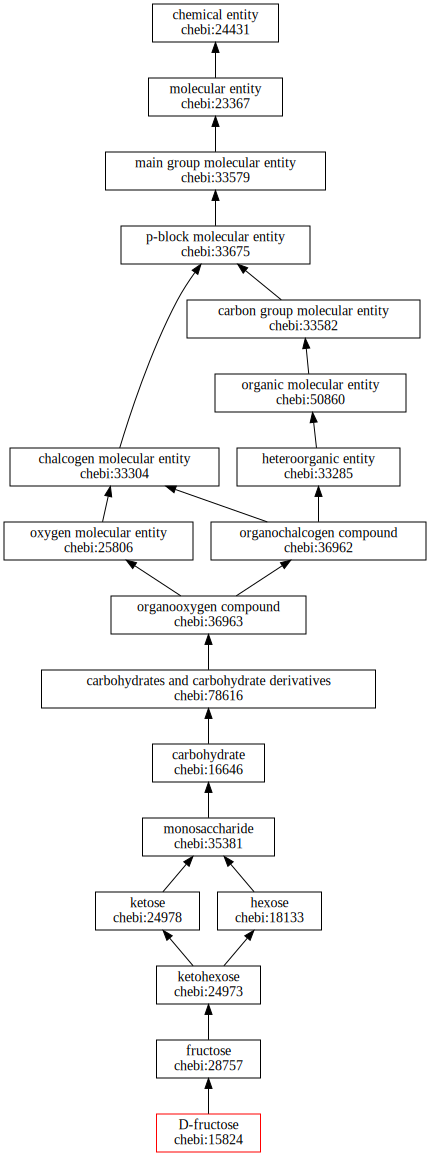

In [8]:
getGraphMoleculeAncestorsHierarchy(["CHEBI:15824"],  SPARQLWrapper(endpointURL), graph = None, highlightMoleculesInList=True)

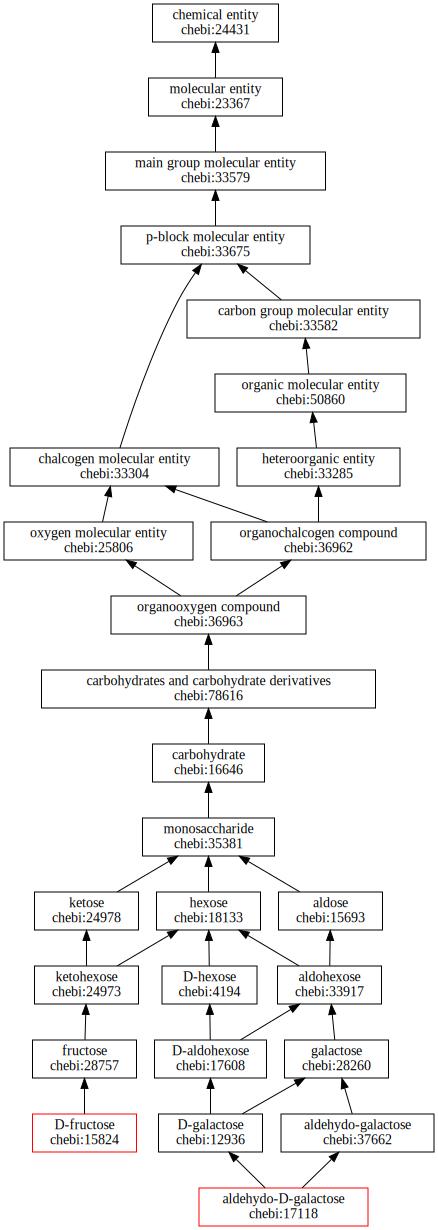

In [9]:
getGraphMoleculeAncestorsHierarchy(["CHEBI:15824", "CHEBI:17118"],  SPARQLWrapper(endpointURL), graph = None, highlightMoleculesInList=True)

In [6]:
def getGraphMoleculeDescendantsHierarchy(moleculeReactomeIdentifierList, sparqlWrapper, graph = None, highlightMoleculesInList=True):
    if graph == None:
        graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
    graph.attr('node', shape='box')
        
    query = """
SELECT DISTINCT ?parent1 ?parentLabel1 ?parent2 ?parentLabel2
WHERE {
  VALUES ?chebiID { #moleculeIdentList# }
  
  BIND (IRI(REPLACE(?chebiID, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?molecule)
  
  ?parent2 rdfs:subClassOf* ?molecule .
  ?parent2 rdf:type owl:Class .
  
  ?parent1 rdfs:subClassOf ?parent2 .
  ?parent1 rdf:type owl:Class .
  OPTIONAL { ?parent1 rdfs:label ?parentLabel1 . }
  OPTIONAL { ?parent2 rdfs:label ?parentLabel2 . }
}
""".replace("#moleculeIdentList#", '"' + '" "'.join(moleculeReactomeIdentifierList) + '"')
    
    sparqlWrapper.setQuery(prefixes+query)
    sparqlWrapper.setReturnFormat(JSON)
    results = sparqlWrapper.query().convert()
    for result in results["results"]["bindings"]:
        parentIdent1 = result["parent1"]["value"].replace(chebiNS, "chebi")
        parentIdent2 = result["parent2"]["value"].replace(chebiNS, "chebi")
        graph.node(parentIdent1, label="{}\n{}".format(result["parentLabel1"]["value"], result["parent1"]["value"].replace(chebiNS, "chebi:")), color="black", shape="box")
        graph.node(parentIdent2, label="{}\n{}".format(result["parentLabel2"]["value"], result["parent2"]["value"].replace(chebiNS, "chebi:")), color="black", shape="box")
        graph.edge(parentIdent1, parentIdent2)
    
    if highlightMoleculesInList:
        for currentMolecule in moleculeReactomeIdentifierList:
            graph.node(currentMolecule.replace("CHEBI:", "chebi"), color="red")
    return graph

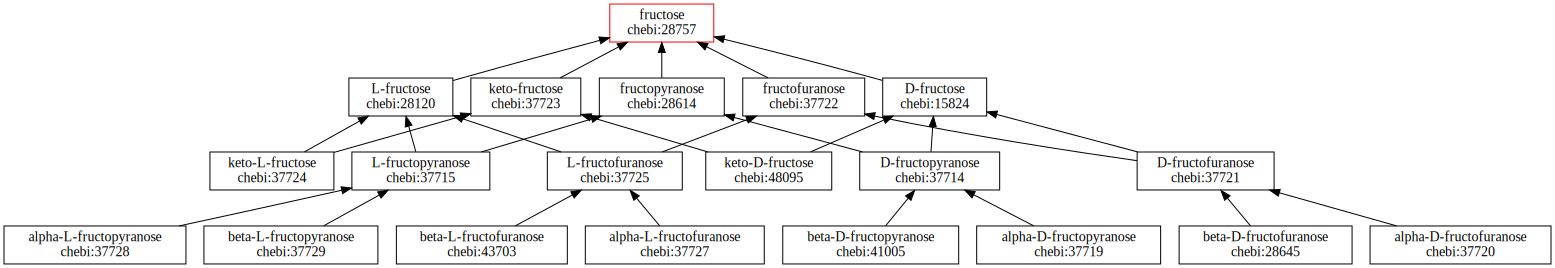

In [7]:
getGraphMoleculeDescendantsHierarchy(["CHEBI:28757"],  SPARQLWrapper(endpointURL), graph = None, highlightMoleculesInList=True)

# 1. Test with Fructose and Galactose

## 1.1 Reaction participants

In [15]:
query = """
#SELECT DISTINCT ?role ?participant ?participantDisplayName 
SELECT DISTINCT ?role ?participantDisplayName ?participantRef ?participantRefName
#SELECT DISTINCT ?rel

WHERE {
  VALUES ?reactionIdent { "R-HSA-70333" } # Fructose
  # VALUES ?reactionIdent { "R-HSA-70355" } # Galactose
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:xref ?reactionXref .
  ?reactionXref bp3:db "Reactome" .
  ?reactionXref bp3:id ?reactionIdent .
  
  ?reaction bp3:left|bp3:right ?participant .
  ?reaction ?role ?participant .
  
  #?participant ?rel ?val .
  #OPTIONAL { ?participant bp3:name ?participantName }
  OPTIONAL { ?participant bp3:displayName ?participantDisplayName }
  
  ?participant bp3:entityReference ?participantRef .
  #?participantRef ?rel ?val .
  OPTIONAL { ?participantRef bp3:name ?participantRefName }
}
ORDER BY ?role ?participant
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    print("{}\t{}\t{}\t{}".format(result["role"]["value"].replace(bp3NS, ""), result["participantDisplayName"]["value"], result["participantRef"]["value"].replace(reactomeNS, ""), result["participantRefName"]["value"]))

left	ATP	SmallMoleculeReference1	ATP
left	ATP	SmallMoleculeReference1	ATP(4-)
left	ATP	SmallMoleculeReference1	ATP(4-) [ChEBI:30616]
left	ATP	SmallMoleculeReference1	Adenosine 5'-triphosphate
left	ATP	SmallMoleculeReference1	atp
left	Fru	SmallMoleculeReference176	D-fructose
left	Fru	SmallMoleculeReference176	D-fructose [ChEBI:15824]
right	ADP	SmallMoleculeReference2	5&apos;-O-[(phosphonatooxy)phosphinato]adenosine
right	ADP	SmallMoleculeReference2	ADP
right	ADP	SmallMoleculeReference2	ADP trianion
right	ADP	SmallMoleculeReference2	ADP(3-)
right	ADP	SmallMoleculeReference2	ADP(3-) [ChEBI:456216]
right	Fru 1-P	SmallMoleculeReference238	keto-D-fructose 1-phosphate
right	Fru 1-P	SmallMoleculeReference238	keto-D-fructose 1-phosphate [ChEBI:18105]


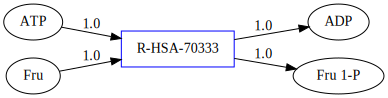

In [8]:
getGraphReaction("R-HSA-70333", SPARQLWrapper(endpointURL), graph = None)

In [16]:
query = """
#SELECT DISTINCT ?role ?participant ?participantDisplayName 
SELECT DISTINCT ?role ?participantDisplayName ?participantRef ?participantRefName
#SELECT DISTINCT ?rel

WHERE {
  #VALUES ?reactionIdent { "R-HSA-70333" } # Fructose
  VALUES ?reactionIdent { "R-HSA-70355" } # Galactose
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:xref ?reactionXref .
  ?reactionXref bp3:db "Reactome" .
  ?reactionXref bp3:id ?reactionIdent .
  
  ?reaction bp3:left|bp3:right ?participant .
  ?reaction ?role ?participant .
  
  #?participant ?rel ?val .
  #OPTIONAL { ?participant bp3:name ?participantName }
  OPTIONAL { ?participant bp3:displayName ?participantDisplayName }
  
  ?participant bp3:entityReference ?participantRef .
  #?participantRef ?rel ?val .
  OPTIONAL { ?participantRef bp3:name ?participantRefName }
}
ORDER BY ?role ?participant
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    print("{}\t{}\t{}\t{}".format(result["role"]["value"].replace(bp3NS, ""), result["participantDisplayName"]["value"], result["participantRef"]["value"].replace(reactomeNS, ""), result["participantRefName"]["value"]))

left	ATP	SmallMoleculeReference1	ATP
left	ATP	SmallMoleculeReference1	ATP(4-)
left	ATP	SmallMoleculeReference1	ATP(4-) [ChEBI:30616]
left	ATP	SmallMoleculeReference1	Adenosine 5'-triphosphate
left	ATP	SmallMoleculeReference1	atp
left	Gal	SmallMoleculeReference177	aldehydo-D-galactose
left	Gal	SmallMoleculeReference177	aldehydo-D-galactose [ChEBI:17118]
right	ADP	SmallMoleculeReference2	5&apos;-O-[(phosphonatooxy)phosphinato]adenosine
right	ADP	SmallMoleculeReference2	ADP
right	ADP	SmallMoleculeReference2	ADP trianion
right	ADP	SmallMoleculeReference2	ADP(3-)
right	ADP	SmallMoleculeReference2	ADP(3-) [ChEBI:456216]
right	Gal1P	SmallMoleculeReference330	alpha-D-galactose 1-phosphate
right	Gal1P	SmallMoleculeReference330	alpha-D-galactose 1-phosphate [ChEBI:17973]


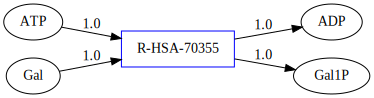

In [9]:
getGraphReaction("R-HSA-70355", SPARQLWrapper(endpointURL), graph = None)

## 1.2 Participants mapping

- Fructose
    - left
        - ATP, SmallMolecule1, SmallMoleculeReference1
        - Fru, SmallMolecule207, SmallMoleculeReference176
    - right
        - ADP, SmallMolecule2, SmallMoleculeReference2
        - Fru 1P, SmallMolecule293, SmallMoleculeReference238
- Galactose
    - left
        - ATP, SmallMolecule1, SmallMoleculeReference1
        - Gal, SmallMolecule208, SmallMoleculeReference177
    - right
        - ADP, SmallMolecule2, SmallMoleculeReference2
        - Gal1P, SmallMolecule422, SmallMoleculeReference238


## 1.3 Generalization

### 1.3.1 Left

In [77]:
query = """
SELECT DISTINCT ?parent1 ?parentLabel1 ?parent2 ?parentLabel2
WHERE {
  #VALUES ?chebiID { "CHEBI:15824" } # D-fructose
  #VALUES ?chebiID { "CHEBI:17118" } # aldehydo-D-galactose
  VALUES ?chebiID { "CHEBI:15824" "CHEBI:17118" }
  
  BIND (IRI(REPLACE(?chebiID, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?molecule)
  
  ?molecule rdfs:subClassOf* ?parent1 .
  ?parent1 rdf:type owl:Class .
  
  ?parent1 rdfs:subClassOf ?parent2 .
  ?parent2 rdf:type owl:Class .
  OPTIONAL { ?parent1 rdfs:label ?parentLabel1 . }
  OPTIONAL { ?parent2 rdfs:label ?parentLabel2 . }
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    print("{}\t{}\t{}\t{}".format(result["parent1"]["value"].replace(chebiNS, "chebi:"), result["parentLabel1"]["value"], result["parent2"]["value"].replace(chebiNS, "chebi:"), result["parentLabel2"]["value"]))
    #print("{}\t{}".format(result["parent1"]["value"].replace(chebiNS, "chebi:"), result["parent2"]["value"].replace(chebiNS, "chebi:")))
    

chebi:15824	D-fructose	chebi:28757	fructose
chebi:28757	fructose	chebi:24973	ketohexose
chebi:24973	ketohexose	chebi:24978	ketose
chebi:24973	ketohexose	chebi:18133	hexose
chebi:24978	ketose	chebi:35381	monosaccharide
chebi:35381	monosaccharide	chebi:16646	carbohydrate
chebi:16646	carbohydrate	chebi:78616	carbohydrates and carbohydrate derivatives
chebi:78616	carbohydrates and carbohydrate derivatives	chebi:36963	organooxygen compound
chebi:36963	organooxygen compound	chebi:36962	organochalcogen compound
chebi:36963	organooxygen compound	chebi:25806	oxygen molecular entity
chebi:36962	organochalcogen compound	chebi:33304	chalcogen molecular entity
chebi:36962	organochalcogen compound	chebi:33285	heteroorganic entity
chebi:33304	chalcogen molecular entity	chebi:33675	p-block molecular entity
chebi:33675	p-block molecular entity	chebi:33579	main group molecular entity
chebi:33579	main group molecular entity	chebi:23367	molecular entity
chebi:23367	molecular entity	chebi:24431	chemical en

In [78]:
graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
graph.attr('node', shape='box')
for result in results["results"]["bindings"]:
    graph.node(result["parent1"]["value"].replace(chebiNS, "chebi"), label="{}\n{}".format(result["parentLabel1"]["value"], result["parent1"]["value"].replace(chebiNS, "chebi:")))
    graph.node(result["parent2"]["value"].replace(chebiNS, "chebi"), label="{}\n{}".format(result["parentLabel2"]["value"], result["parent2"]["value"].replace(chebiNS, "chebi:")))
    graph.edge(result["parent1"]["value"].replace(chebiNS, "chebi"), result["parent2"]["value"].replace(chebiNS, "chebi"))
graph.node("chebi15824", color="red")
graph.node("chebi17118", color="red")

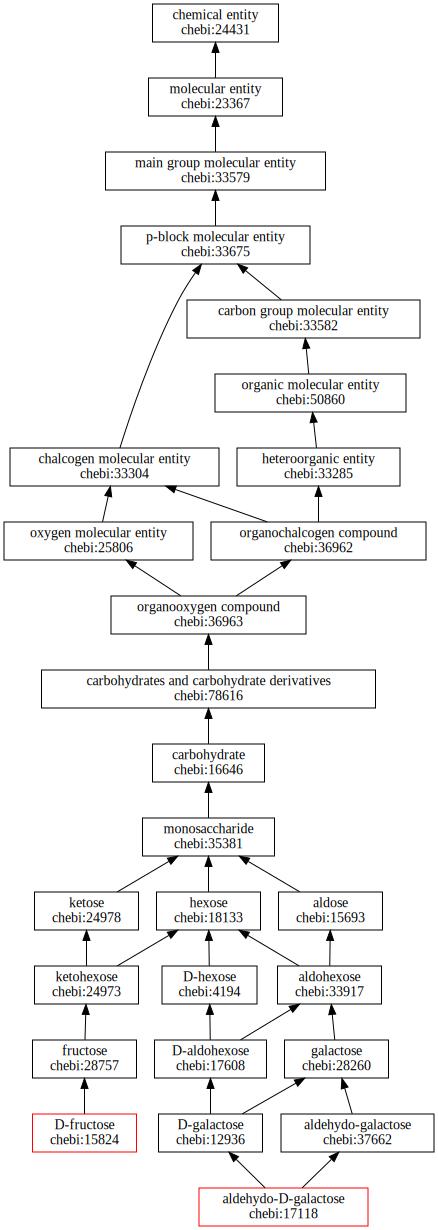

In [79]:
graph

In [80]:
query = """
SELECT DISTINCT ?lca
WHERE {
  VALUES ?chebiID1 { "CHEBI:15824" } # D-fructose
  VALUES ?chebiID2 { "CHEBI:17118" } # aldehydo-D-galactose
  
  
  BIND (IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?molecule1)
  BIND (IRI(REPLACE(?chebiID2, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?molecule2)
  
  ?molecule1 rdfs:subClassOf* ?lca .
  ?molecule2 rdfs:subClassOf* ?lca .
  ?lca rdf:type owl:Class .
  
  FILTER NOT EXISTS {
    ?molecule1 rdfs:subClassOf* ?intermediateParent .
    ?molecule2 rdfs:subClassOf* ?intermediateParent .
    ?intermediateParent rdf:type owl:Class .
    ?intermediateParent rdfs:subClassOf+ ?lca .
  }
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    print(result["lca"]["value"].replace(chebiNS, "chebi:"))
    graph.node(format(result["lca"]["value"].replace(chebiNS, "chebi")), color="blue")


chebi:18133


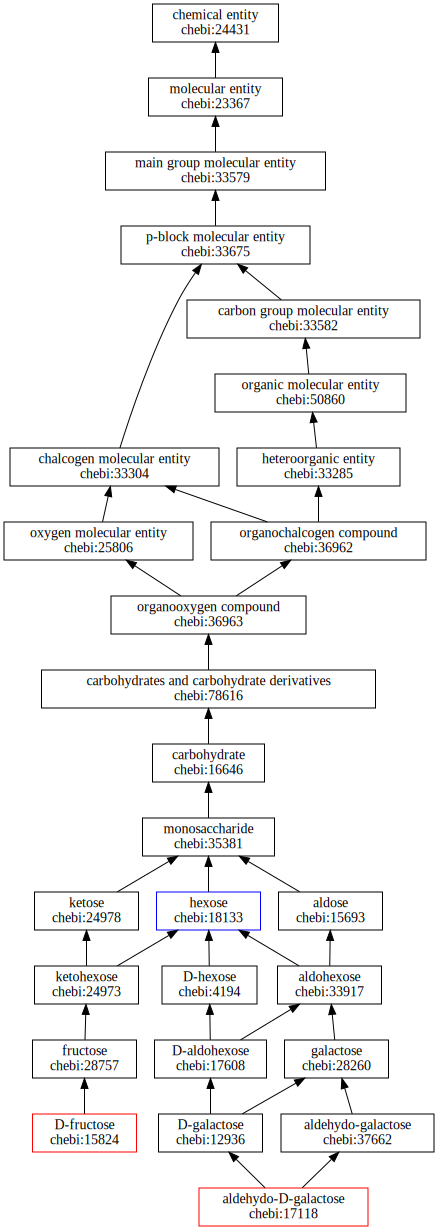

In [81]:
graph

### 1.3.2 Right

In [82]:
query = """
SELECT DISTINCT ?parent1 ?parentLabel1 ?parent2 ?parentLabel2
WHERE {
  #VALUES ?chebiID { "CHEBI:15824" } # D-fructose
  #VALUES ?chebiID { "CHEBI:17118" } # aldehydo-D-galactose
  #VALUES ?chebiID { "CHEBI:15824" "CHEBI:17118" }
  
  VALUES ?chebiID { "CHEBI:18105" "CHEBI:17973" }
  
  BIND (IRI(REPLACE(?chebiID, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?molecule)
  
  ?molecule rdfs:subClassOf* ?parent1 .
  ?parent1 rdf:type owl:Class .
  
  ?parent1 rdfs:subClassOf ?parent2 .
  ?parent2 rdf:type owl:Class .
  OPTIONAL { ?parent1 rdfs:label ?parentLabel1 . }
  OPTIONAL { ?parent2 rdfs:label ?parentLabel2 . }
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    print("{}\t{}\t{}\t{}".format(result["parent1"]["value"].replace(chebiNS, "chebi:"), result["parentLabel1"]["value"], result["parent2"]["value"].replace(chebiNS, "chebi:"), result["parentLabel2"]["value"]))
    #print("{}\t{}".format(result["parent1"]["value"].replace(chebiNS, "chebi:"), result["parent2"]["value"].replace(chebiNS, "chebi:")))
    

chebi:18105	keto-D-fructose 1-phosphate	chebi:78736	D-fructose 1-phosphate
chebi:78736	D-fructose 1-phosphate	chebi:78737	fructose 1-phosphate
chebi:78737	fructose 1-phosphate	chebi:24971	ketohexose monophosphate
chebi:24971	ketohexose monophosphate	chebi:24972	ketohexose phosphate
chebi:24972	ketohexose phosphate	chebi:47878	hexose phosphate
chebi:24972	ketohexose phosphate	chebi:35132	ketose phosphate
chebi:47878	hexose phosphate	chebi:63385	hexose derivative
chebi:47878	hexose phosphate	chebi:33447	phospho sugar
chebi:63385	hexose derivative	chebi:63367	monosaccharide derivative
chebi:63367	monosaccharide derivative	chebi:63299	carbohydrate derivative
chebi:63299	carbohydrate derivative	chebi:78616	carbohydrates and carbohydrate derivatives
chebi:78616	carbohydrates and carbohydrate derivatives	chebi:36963	organooxygen compound
chebi:36963	organooxygen compound	chebi:36962	organochalcogen compound
chebi:36963	organooxygen compound	chebi:25806	oxygen molecular entity
chebi:36962	orga

In [83]:
graph = graphviz.Digraph(graph_attr={'rankdir': 'BT'})
graph.attr('node', shape='box')
for result in results["results"]["bindings"]:
    graph.node(result["parent1"]["value"].replace(chebiNS, "chebi"), label="{}\n{}".format(result["parentLabel1"]["value"], result["parent1"]["value"].replace(chebiNS, "chebi:")))
    graph.node(result["parent2"]["value"].replace(chebiNS, "chebi"), label="{}\n{}".format(result["parentLabel2"]["value"], result["parent2"]["value"].replace(chebiNS, "chebi:")))
    graph.edge(result["parent1"]["value"].replace(chebiNS, "chebi"), result["parent2"]["value"].replace(chebiNS, "chebi"))
graph.node("chebi18105", color="red")
graph.node("chebi17973", color="red")

In [84]:
query = """
SELECT DISTINCT ?lca
WHERE {
  #VALUES ?chebiID1 { "CHEBI:15824" } # D-fructose
  #VALUES ?chebiID2 { "CHEBI:17118" } # aldehydo-D-galactose
  
  VALUES ?chebiID1 { "CHEBI:18105" } # 
  VALUES ?chebiID2 { "CHEBI:17973" } # 
  
  
  
  BIND (IRI(REPLACE(?chebiID1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?molecule1)
  BIND (IRI(REPLACE(?chebiID2, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?molecule2)
  
  ?molecule1 rdfs:subClassOf* ?lca .
  ?molecule2 rdfs:subClassOf* ?lca .
  ?lca rdf:type owl:Class .
  
  FILTER NOT EXISTS {
    ?molecule1 rdfs:subClassOf* ?intermediateParent .
    ?molecule2 rdfs:subClassOf* ?intermediateParent .
    ?intermediateParent rdf:type owl:Class .
    ?intermediateParent rdfs:subClassOf+ ?lca .
  }
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    print(result["lca"]["value"].replace(chebiNS, "chebi:"))
    graph.node(format(result["lca"]["value"].replace(chebiNS, "chebi")), color="blue")


chebi:47878


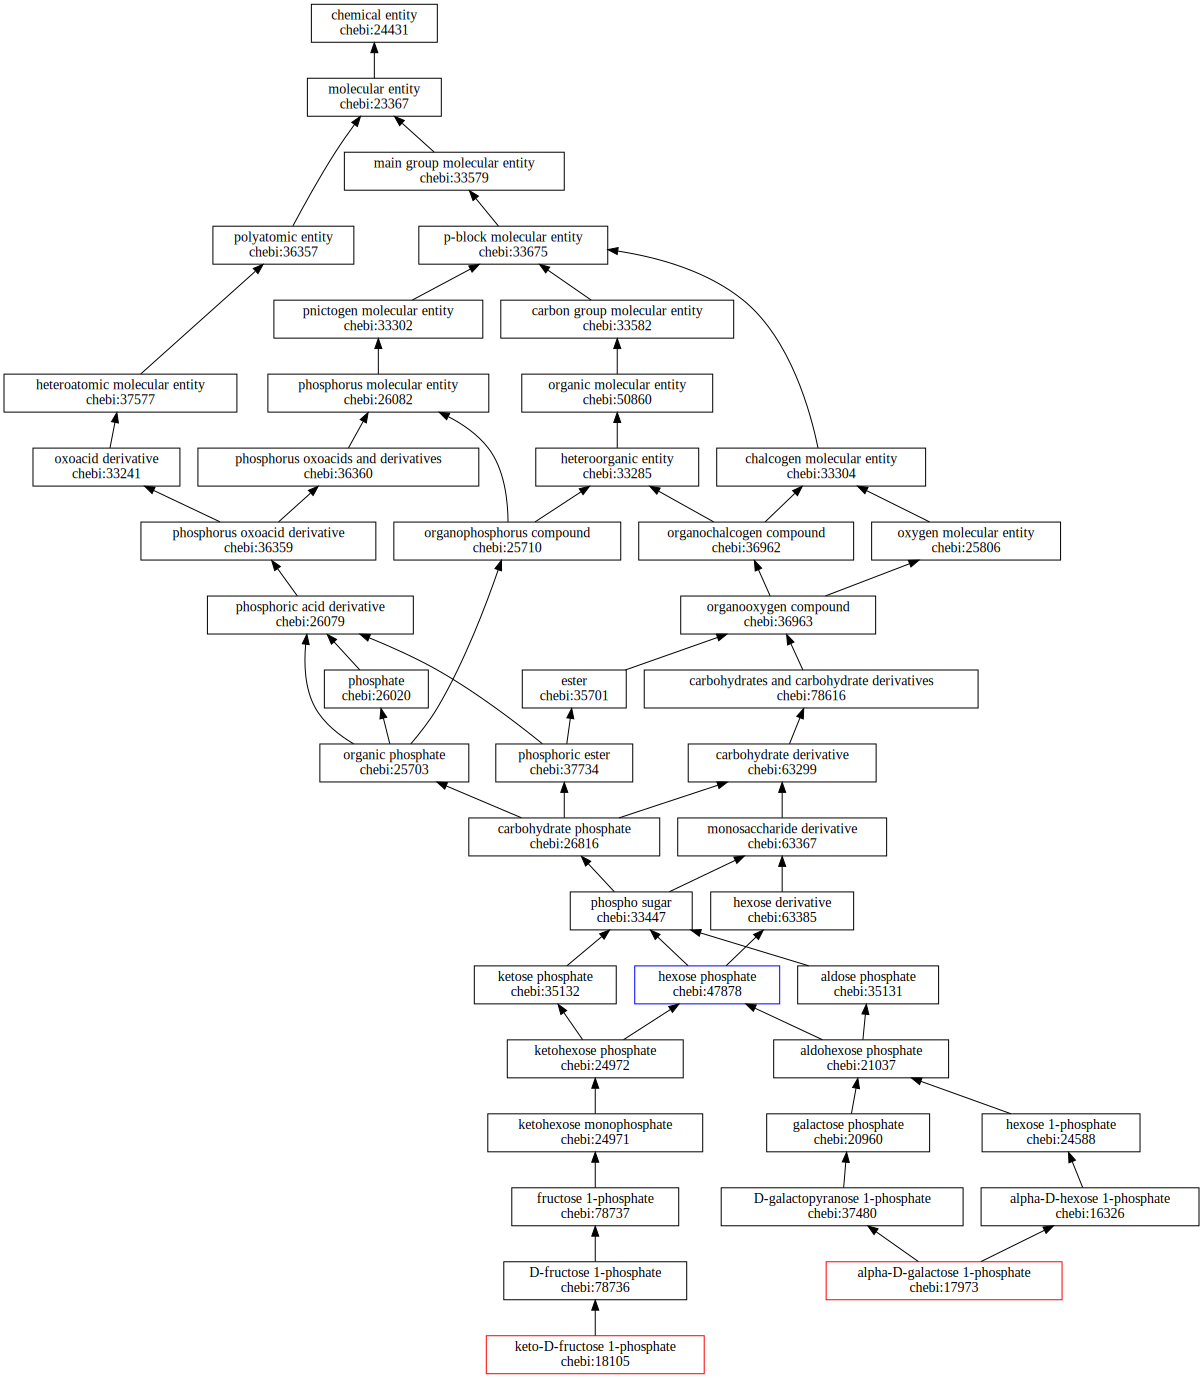

In [85]:
graph

## 1.4 Equivalent reactions

In [11]:
query = """
#SELECT DISTINCT ?role ?participant ?participantDisplayName 
#SELECT DISTINCT ?role ?participantDisplayName ?participantRef ?participantRefName
#SELECT DISTINCT ?rel
SELECT DISTINCT ?reaction ?reactionIdent

WHERE {
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:xref ?reactionXref .
  ?reactionXref bp3:db "Reactome" .
  ?reactionXref bp3:id ?reactionIdent .
  
  ?reaction bp3:left/bp3:entityReference/bp3:xref ?participantXref1 .
  ?participantXref1 bp3:db "ChEBI" .
  ?participantXref1 bp3:id ?participantChebi1 .
  BIND(IRI(REPLACE(?participantChebi1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi1)
  ?chebi1 rdfs:subClassOf* chebidb:18133 . # hexose
  
  ?reaction bp3:left/bp3:entityReference/bp3:xref ?participantXref2 .
  ?participantXref2 bp3:db "ChEBI" .
  ?participantXref2 bp3:id ?participantChebi2 .
  BIND(IRI(REPLACE(?participantChebi2, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi2)
  ?chebi2 rdfs:subClassOf* chebidb:30616 . # ATP(4-)
  
  ?reaction bp3:right/bp3:entityReference/bp3:xref ?participantXref3 .
  ?participantXref3 bp3:db "ChEBI" .
  ?participantXref3 bp3:id ?participantChebi3 .
  BIND(IRI(REPLACE(?participantChebi3, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi3)
  ?chebi3 rdfs:subClassOf* chebidb:47878 . # hexose-phosphate
  
  ?reaction bp3:right/bp3:entityReference/bp3:xref ?participantXref4 .
  ?participantXref4 bp3:db "ChEBI" .
  ?participantXref4 bp3:id ?participantChebi4 .
  BIND(IRI(REPLACE(?participantChebi4, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi4)
  ?chebi4 rdfs:subClassOf* chebidb:456216 . # ADP3-
  
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    #print("{}\t{}\t{}\t{}".format(result["role"]["value"].replace(bp3NS, ""), result["participantDisplayName"]["value"], result["participantRef"]["value"].replace(reactomeNS, ""), result["participantRefName"]["value"]))
    print("{}\t{}".format(result["reaction"]["value"].replace(reactomeNS, ""), result["reactionIdent"]["value"]))
    getGraphReaction(result["reactionIdent"]["value"], SPARQLWrapper(endpointURL), graph = None)

BiochemicalReaction11607	R-HSA-70333
BiochemicalReaction6099	R-HSA-6787540
BiochemicalReaction11615	R-HSA-70355


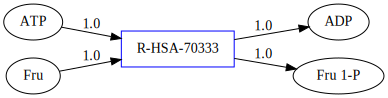

In [12]:
getGraphReaction("R-HSA-70333", SPARQLWrapper(endpointURL), graph = None)

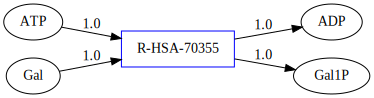

In [13]:
getGraphReaction("R-HSA-70355", SPARQLWrapper(endpointURL), graph = None)

In [14]:
getGraphReaction("R-HSA-6787540", SPARQLWrapper(endpointURL), graph = None)

In [91]:
query = """
#SELECT DISTINCT ?role ?participant ?participantDisplayName 
#SELECT DISTINCT ?role ?participantDisplayName ?participantRef ?participantRefName
#SELECT DISTINCT ?rel
SELECT DISTINCT ?reaction ?reactionIdent

WHERE {
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:xref ?reactionXref .
  ?reactionXref bp3:db "Reactome" .
  ?reactionXref bp3:id ?reactionIdent .
  
  ?reaction bp3:left/bp3:entityReference/bp3:xref ?participantXref1 .
  ?participantXref1 bp3:db "ChEBI" .
  ?participantXref1 bp3:id ?participantChebi1 .
  BIND(IRI(REPLACE(?participantChebi1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi1)
  ?chebi1 rdfs:subClassOf* chebidb:16646 . # carbohydrate
  
  ?reaction bp3:left/bp3:entityReference/bp3:xref ?participantXref2 .
  ?participantXref2 bp3:db "ChEBI" .
  ?participantXref2 bp3:id ?participantChebi2 .
  BIND(IRI(REPLACE(?participantChebi2, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi2)
  ?chebi2 rdfs:subClassOf* chebidb:30616 . # ATP(4-)
  
  ?reaction bp3:right/bp3:entityReference/bp3:xref ?participantXref3 .
  ?participantXref3 bp3:db "ChEBI" .
  ?participantXref3 bp3:id ?participantChebi3 .
  BIND(IRI(REPLACE(?participantChebi3, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi3)
  ?chebi3 rdfs:subClassOf* chebidb:26816 . #  carbohydrate phosphate
  
  ?reaction bp3:right/bp3:entityReference/bp3:xref ?participantXref4 .
  ?participantXref4 bp3:db "ChEBI" .
  ?participantXref4 bp3:id ?participantChebi4 .
  BIND(IRI(REPLACE(?participantChebi4, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi4)
  ?chebi4 rdfs:subClassOf* chebidb:456216 . # ADP3-
  
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    #print("{}\t{}\t{}\t{}".format(result["role"]["value"].replace(bp3NS, ""), result["participantDisplayName"]["value"], result["participantRef"]["value"].replace(reactomeNS, ""), result["participantRefName"]["value"]))
    print("{}\t{}".format(result["reaction"]["value"].replace(reactomeNS, ""), result["reactionIdent"]["value"]))

BiochemicalReaction11634	R-HSA-8959719
BiochemicalReaction11607	R-HSA-70333
BiochemicalReaction6099	R-HSA-6787540
BiochemicalReaction11615	R-HSA-70355


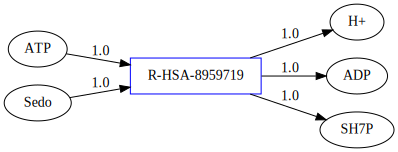

In [15]:
getGraphReaction("R-HSA-8959719", SPARQLWrapper(endpointURL), graph = None)

In [93]:
query = """
#SELECT DISTINCT ?role ?participant ?participantDisplayName 
#SELECT DISTINCT ?role ?participantDisplayName ?participantRef ?participantRefName
#SELECT DISTINCT ?rel
SELECT DISTINCT ?reaction ?reactionIdent

WHERE {
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:xref ?reactionXref .
  ?reactionXref bp3:db "Reactome" .
  ?reactionXref bp3:id ?reactionIdent .
  
  ?reaction bp3:left/bp3:entityReference/bp3:xref ?participantXref1 .
  ?participantXref1 bp3:db "ChEBI" .
  ?participantXref1 bp3:id ?participantChebi1 .
  BIND(IRI(REPLACE(?participantChebi1, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi1)
  ?chebi1 rdfs:subClassOf* chebidb:23367 . # molecular entity
  
  ?reaction bp3:left/bp3:entityReference/bp3:xref ?participantXref2 .
  ?participantXref2 bp3:db "ChEBI" .
  ?participantXref2 bp3:id ?participantChebi2 .
  BIND(IRI(REPLACE(?participantChebi2, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi2)
  ?chebi2 rdfs:subClassOf* chebidb:30616 . # ATP(4-)
  
  ?reaction bp3:right/bp3:entityReference/bp3:xref ?participantXref3 .
  ?participantXref3 bp3:db "ChEBI" .
  ?participantXref3 bp3:id ?participantChebi3 .
  BIND(IRI(REPLACE(?participantChebi3, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi3)
  ?chebi3 rdfs:subClassOf* chebidb:26020 . # phosphate
  
  ?reaction bp3:right/bp3:entityReference/bp3:xref ?participantXref4 .
  ?participantXref4 bp3:db "ChEBI" .
  ?participantXref4 bp3:id ?participantChebi4 .
  BIND(IRI(REPLACE(?participantChebi4, "CHEBI:", "http://purl.obolibrary.org/obo/CHEBI_")) AS ?chebi4)
  ?chebi4 rdfs:subClassOf* chebidb:456216 . # ADP3-
  
}
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    #print("{}\t{}\t{}\t{}".format(result["role"]["value"].replace(bp3NS, ""), result["participantDisplayName"]["value"], result["participantRef"]["value"].replace(reactomeNS, ""), result["participantRefName"]["value"]))
    print("{}\t{}".format(result["reaction"]["value"].replace(reactomeNS, ""), result["reactionIdent"]["value"]))

BiochemicalReaction11778	R-HSA-1855224
BiochemicalReaction12251	R-HSA-1675928
BiochemicalReaction13064	R-HSA-964962
BiochemicalReaction5335	R-HSA-426240
BiochemicalReaction5014	R-HSA-5672012
BiochemicalReaction12261	R-HSA-1676145
BiochemicalReaction10830	R-HSA-8868072
BiochemicalReaction13115	R-HSA-8869633
BiochemicalReaction12384	R-HSA-191422
BiochemicalReaction6686	R-HSA-5678706
BiochemicalReaction11592	R-HSA-71802
BiochemicalReaction11787	R-HSA-1855223
BiochemicalReaction11789	R-HSA-1855193
BiochemicalReaction13123	R-HSA-8955030
BiochemicalReaction11794	R-HSA-1855158
BiochemicalReaction11634	R-HSA-8959719
BiochemicalReaction12373	R-HSA-1638845
BiochemicalReaction12133	R-HSA-1483222
BiochemicalReaction11607	R-HSA-70333
BiochemicalReaction12243	R-HSA-1676185
BiochemicalReaction11775	R-HSA-1855181
BiochemicalReaction12296	R-HSA-1675974
BiochemicalReaction13234	R-HSA-70773
BiochemicalReaction6099	R-HSA-6787540
BiochemicalReaction12238	R-HSA-1675813
BiochemicalReaction6075	R-HSA-4085028


In [ ]:
query = """
#SELECT DISTINCT ?role ?participant ?participantDisplayName 
SELECT DISTINCT ?role ?participantDisplayName ?participantRef ?participantRefName
#SELECT DISTINCT ?rel

WHERE {
  VALUES ?reactionIdent { "R-HSA-70333" } # Fructose
  ?reaction rdf:type bp3:BiochemicalReaction .
  ?reaction bp3:xref ?reactionXref .
  ?reactionXref bp3:db "Reactome" .
  ?reactionXref bp3:id ?reactionIdent .
  
  ?reaction bp3:left|bp3:right ?participant .
  ?reaction ?role ?participant .
  
  #?participant ?rel ?val .
  #OPTIONAL { ?participant bp3:name ?participantName }
  OPTIONAL { ?participant bp3:displayName ?participantDisplayName }
  
  ?participant bp3:entityReference ?participantRef .
  #?participantRef ?rel ?val .
  OPTIONAL { ?participantRef bp3:name ?participantRefName }
}
ORDER BY ?role ?participant
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    print("{}\t{}\t{}\t{}".format(result["role"]["value"].replace(bp3NS, ""), result["participantDisplayName"]["value"], result["participantRef"]["value"].replace(reactomeNS, ""), result["participantRefName"]["value"]))